In [1]:
from owslib.wmts import WebMapTileService
import pandas as pd
from IPython.display import Image, display
import time
import WMTS_General_Map as general
config = general.get_config_from_json()

In [2]:
try:
    wmts_avoin = WebMapTileService(config["wmts"]["avoin"])
    time.sleep(0.01)
    wmts_maasto = WebMapTileService(config["wmts"]["maasto"])
except Exception as e:
    print(e)
tile_matrix_set_name = config["matrix"]["set_name"]
map_layer = config["matrix"]["map_layer"]["orto"]
standardized_rendering_pixel_size = config["standardized_rendering_pixel_size"]

In [3]:
def get_boxes_by__matrix(matrix):
    delta_width = matrix.tilewidth * standardized_rendering_pixel_size * matrix.scaledenominator
    delta_height = matrix.tileheight * standardized_rendering_pixel_size * matrix.scaledenominator
    boxes_dict = dict()
    for tile_height_pos in range(matrix.matrixheight):
        for tile_width_pos in range(matrix.matrixwidth):
            left_lon = matrix.topleftcorner[0] + (tile_width_pos * delta_width)
            left_lat = matrix.topleftcorner[1] - (tile_height_pos * delta_height)
            right_lon = matrix.topleftcorner[0] + ((tile_width_pos + 1) * delta_width)
            right_lat = matrix.topleftcorner[1] - ((tile_height_pos + 1) * delta_height)
            left = general.convert_coordinate_systems(lat=left_lat, lon=left_lon)
            right = general.convert_coordinate_systems(right_lat, right_lon)

            combined = dict(left=left, right=right)
            boxes_dict[tile_height_pos, tile_width_pos] = combined
    return boxes_dict


In [4]:
def get_boxes_by_df(matrix):
    boxes = get_boxes_by__matrix(matrix)
    df = pd.DataFrame(boxes).T
    df_ = pd.concat([df['left'].apply(pd.Series), df['right'].apply(pd.Series)], keys=['left', 'right'], axis=1)
    return df_


In [5]:
def get_column_row_for_coordinate_at_level(latitude, longitude, wmts_, tileset=None, level=2, df=None):
    if tileset == None and df == None:
        tileset = wmts_.tilematrixsets[tile_matrix_set_name]
        list_of_tilematrixes = list(tileset.tilematrix.keys())
        df = get_boxes_by_df(tileset.tilematrix[list_of_tilematrixes[level]])
    searched_df = df[(df['left'][0] <= longitude)
                     & (longitude <= df['right'][0])
                     & (df['left'][1] >= latitude)
                     & (latitude >= df['right'][1])]
    index_ = searched_df.index
    if len(index_.to_list()) == 0:
        print(index_)
        display(df)
        display(searched_df)
        return
    codes = index_.to_list()[-1]
    return codes, df


In [6]:
def get_image_for_coordinate(latitude, longitude, level, wmts_, specified_map_layer=map_layer):
    codes, df_ = get_column_row_for_coordinate_at_level(latitude=latitude,
                                                        longitude=longitude,
                                                        wmts_=wmts_,
                                                        level=level)
    tile = wmts_.gettile(layer=specified_map_layer,
                         tilematrixset=tile_matrix_set_name,
                         tilematrix='{0}'.format(level),
                         row=codes[0],
                         column=codes[1],
                         format= wmts_.contents[specified_map_layer].formats[0])
    out = open('test.jpg', 'wb')
    out.write(tile.read())
    out.close()
    display(Image(filename='test.jpg'))


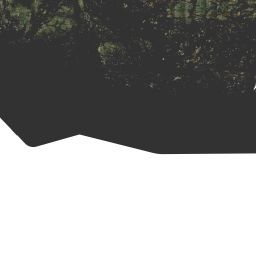

In [13]:
info_dict = general.get_coordinates_from_file()[0]
get_image_for_coordinate(info_dict['latitude'], info_dict['longitude'],4, wmts_=wmts_avoin)
